# Operator Inference demo: 1-dimensional heat data

In [1]:
import h5py
import numpy as np
from scipy import linalg as la
from matplotlib import pyplot as plt

from operator_inference import OpInf, opinf_helper

In [2]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True

## Preprocessing

We begin by loading some data, splitting it into training/testing sets, and computing an appropriate POD basis for the data.

**NOTE**: as is, the snapshot matrices are stacked row-wise; that is, each row is a snapshot. But then why isn't the POD basis computed for the snapshots transposed? 🤔

In [4]:
# Load some heat data (1D snapshots)
with h5py.File('heat_opinf_data.h5','r') as hf:
    train_snapshots = hf['train_snapshots'][:,:]
    original_data = hf['snapshots'][:,:]
    part_test_l = hf['particular_test_left'][:,:]
    part_test_r = hf['particular_test_right'][:,:]
    part_train_l = hf['particular_train_left'][:,:]
    part_train_r = hf['particular_train_right'][:,:]

In [5]:
# Extract data parameters.
n_t = original_data.shape[1]        # total number of snapshots
d = original_data.shape[0]          # length of each snapshot

# Spatial domain
x = np.linspace(0, 4, d)

# time step size
dt = 0.01

# number of training snapshots
train_size = train_snapshots.shape[1]

# number of testing snapshots
test_size = n_t - train_size

In [6]:
# Compute POD basis
[U,S,V] = la.svd(train_snapshots, full_matrices=False)
r = 15
print("Rank of POD basis:", r)

# Project data onto POD basis.
xhat = (U[:,:r].T) @ train_snapshots

# compute the reduced time derivative
xdot = np.zeros_like(xhat)
xdot[:,2:-2] = (xhat[:,0:-4] - 8*xhat[:,1:-3] + 8*xhat[:,3:-1] - xhat[:,4:])/(12*dt)
xdot[:,0] = (xhat[:,1] - xhat[:,0])/dt
xdot[:,1] = (xhat[:,2] - xhat[:,1])/dt
xdot[:,-1] = (xhat[:,-1] - xhat[:,-2])/dt
xdot[:,-2] = (xhat[:,-2] - xhat[:,-3])/dt

Rank of POD basis: 15


### Operator Inference Part

In [7]:
# Instantiate a linear model with constant term and no control inputs.
mymodel = OpInf.ReducedModel('Lc', False)

# Fit the model.
mymodel.fit(r, 0, xdot, xhat) # No L2 regularization

In [8]:
# Simulate the model for train and test time steps
xr, break_point = mymodel.predict(xhat[:,0], n_t, dt)

In [9]:
# Reconstruct the predictions.
xr_rec = U[:,:r] @ xr

# Add the particular back
xr_rec[:,train_size:] = xr_rec[:,train_size:] + part_test_l + part_test_r
xr_rec[:,:train_size] = xr_rec[:,:train_size] + part_train_l+ part_train_r

## Results

In [10]:
alphs = np.linspace(1,0.5,int((n_t)))
time = np.linspace(0,2*np.pi,n_t)

xticks = [0, 2, 4]
xticklabels = [r"$0$", r"$\frac{L}{2}$", r"$L$"]
yticks = [i*np.pi/3 for i in range(7)]
yticklabels = [r"0", r"$\frac{\pi}{3}$", r"$\frac{2\pi}{3}$", r"$\pi$",
                r"$\frac{4\pi}{3}$", r"$\frac{5\pi}{3}$", r"$2\pi$"]

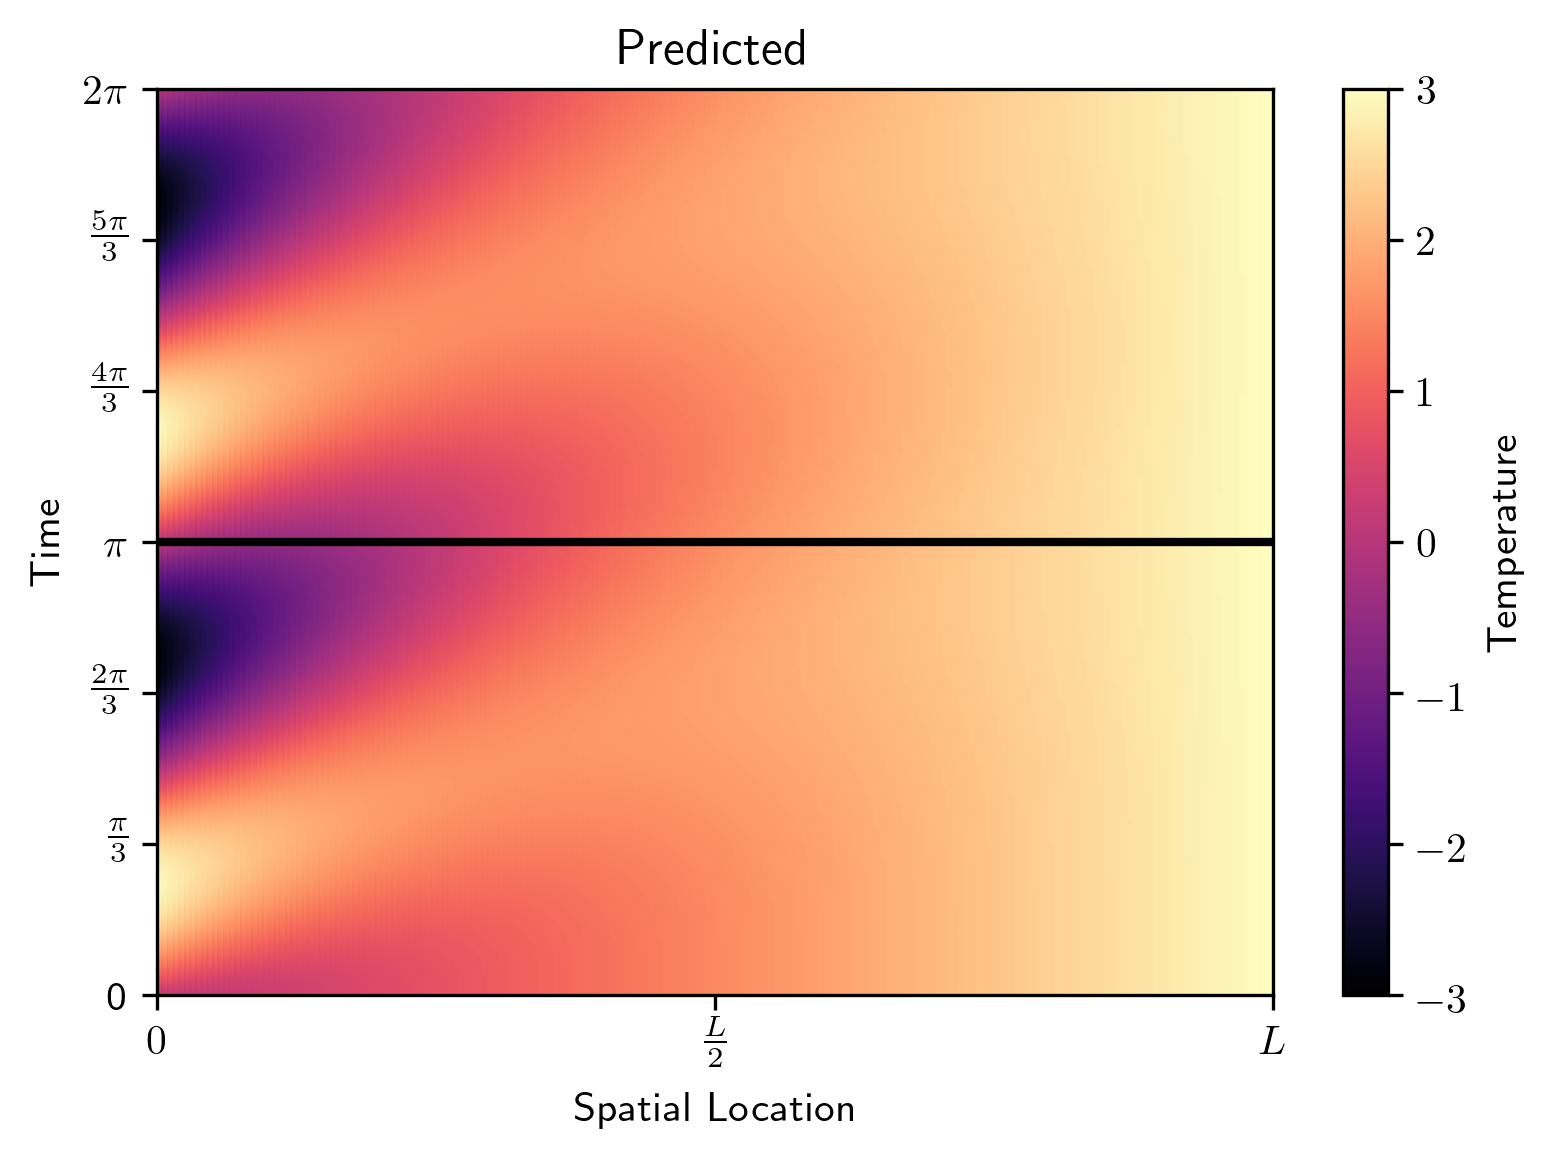

In [11]:
for jj in range(d):
    plt.scatter(x[jj]*np.ones(len(time)), time,
                c=xr_rec[jj,:], s=5, cmap="magma", vmin=-3, vmax=3)
plt.plot(x, np.ones(d)*np.pi, 'k-', lw=2)

plt.axis([x.min(), x.max(), 0, 2*np.pi])
plt.xlabel("Spatial Location")
plt.ylabel("Time")
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)

plt.title("Predicted")

plt.colorbar(label="Temperature", norm=plt.Normalize(vmin=-3, vmax=3))
plt.show()

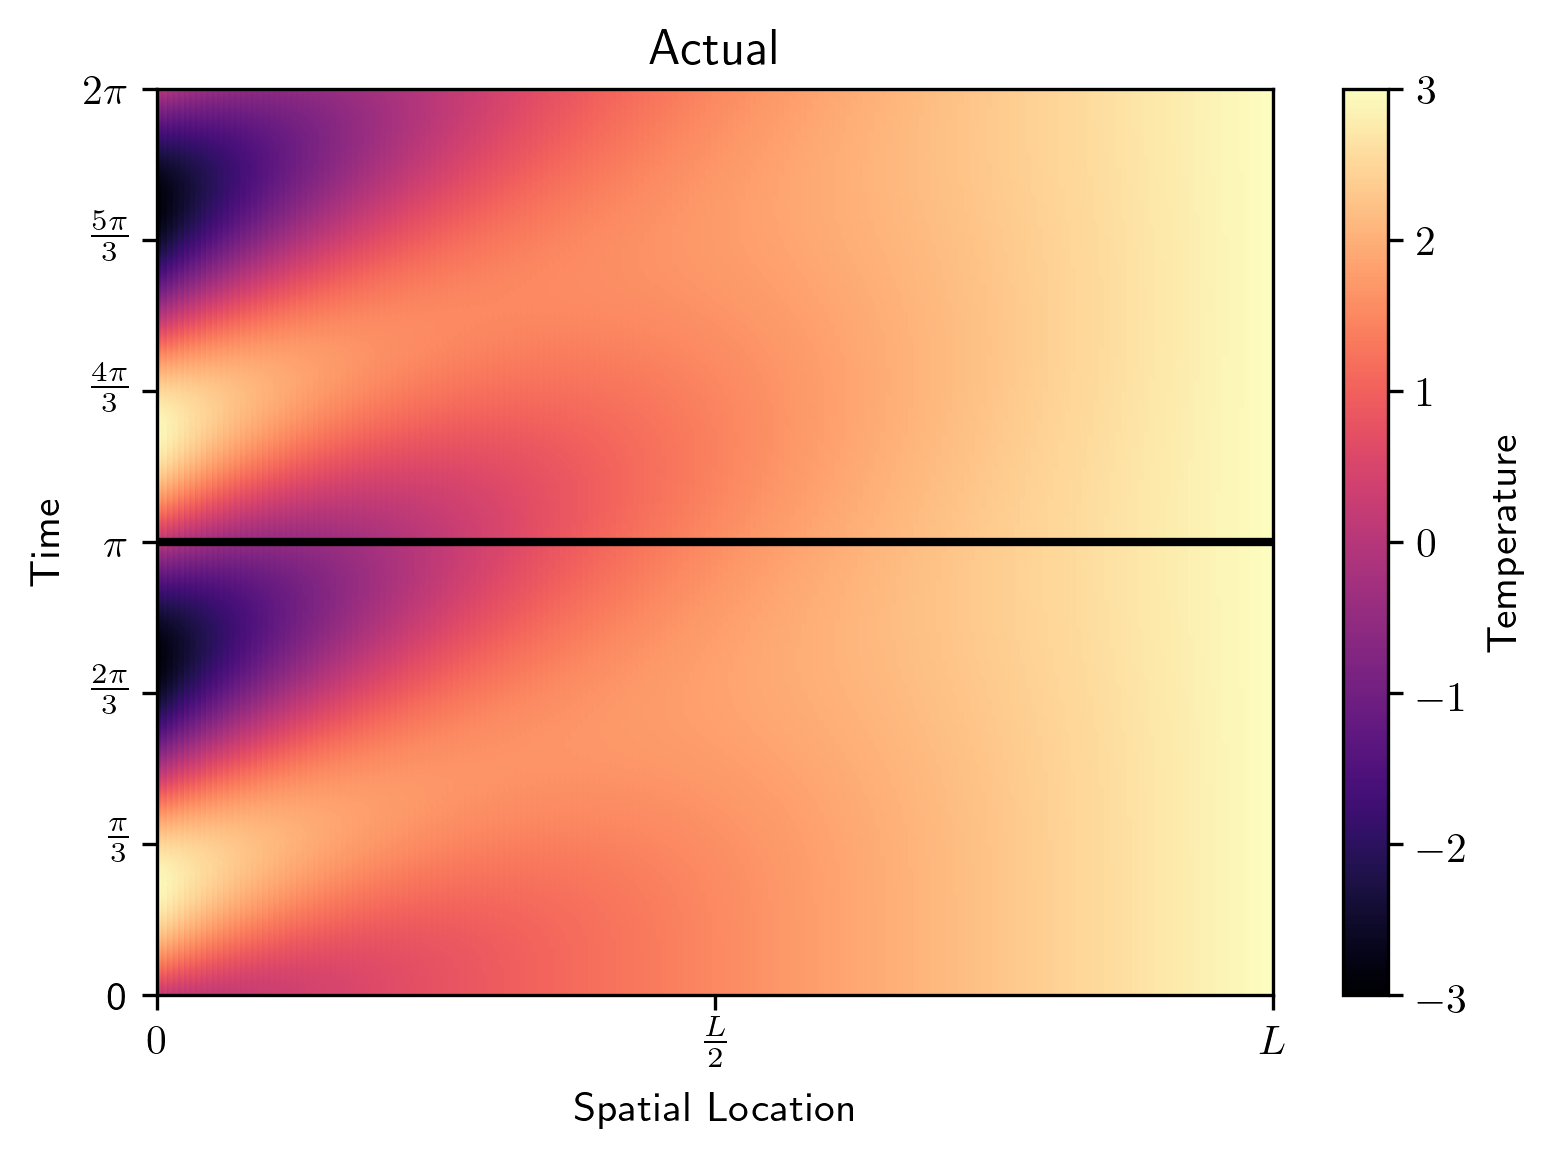

In [12]:
for jj in range(d):
    plt.scatter(x[jj]*np.ones(len(time)), time,
                c=original_data[jj,:], s=5, cmap="magma", vmin=-3, vmax=3)
plt.plot(x, np.ones(d)*np.pi, color='k', lw=2)

plt.axis([x.min(), x.max(), 0, 2*np.pi])
plt.xlabel("Spatial Location")
plt.ylabel("Time")
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)

plt.title("Actual")
plt.colorbar(label="Temperature", norm=plt.Normalize(vmin=-3, vmax=3))
plt.show()

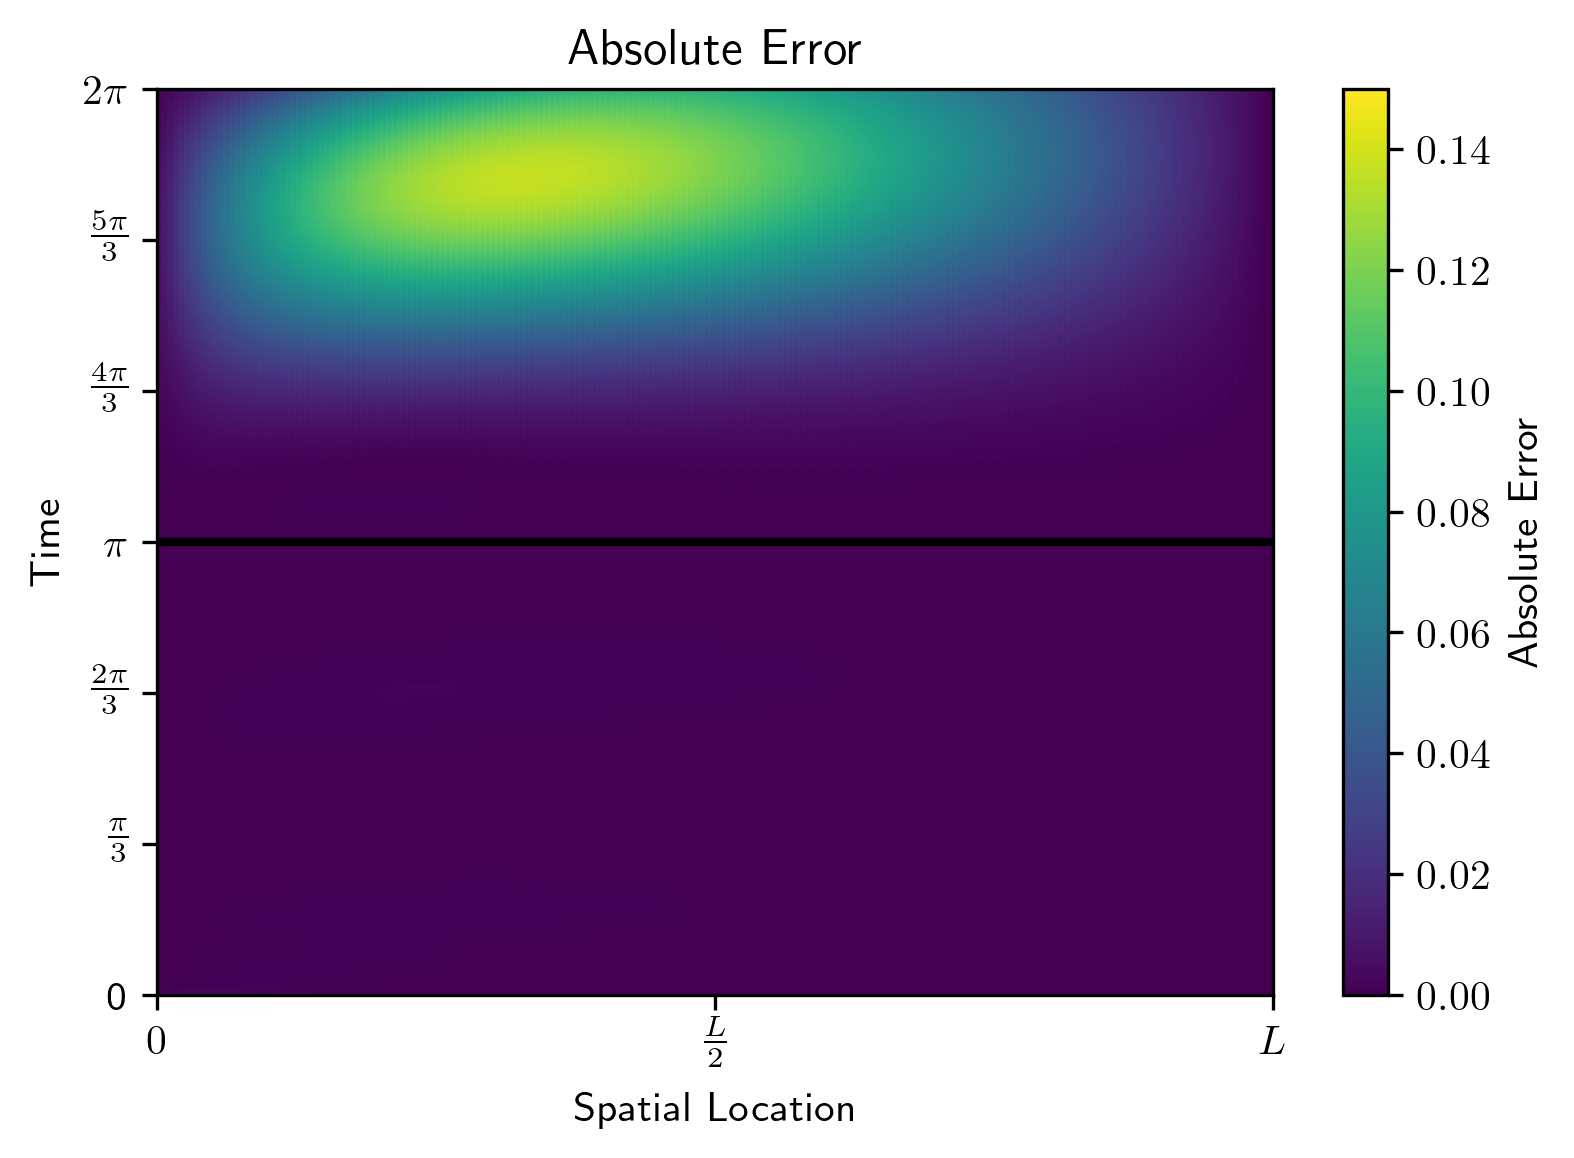

In [13]:
for jj in range(d):
    plt.scatter(x[jj]*np.ones(len(time)), time,
                c=np.abs(xr_rec[jj,:] - original_data[jj,:]), s=5, cmap="viridis", vmin=0, vmax=.15)
plt.plot(x, np.ones(d)*np.pi, color='k', lw=2)

plt.axis([x.min(), x.max(), 0, 2*np.pi])
plt.xlabel("Spatial Location")
plt.ylabel("Time")
plt.xticks(xticks, xticklabels)
plt.yticks(yticks, yticklabels)

plt.title("Absolute Error")

plt.colorbar(label="Absolute Error", norm=plt.Normalize(vmin=0, vmax=.15))
plt.show()